In [1]:
from os import listdir
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy import stats
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [2]:
# Print versions
!python --version
print('Numpy ' + np.__version__)
print('TensorFlow ' + tf.__version__)
print('Keras ' + tf.keras.__version__)

Python 3.7.6
Numpy 1.18.1
TensorFlow 2.1.0
Keras 2.2.4-tf


In [3]:
# Settings
dataset_path = 'ceiling-fan-dataset'  # Directory where raw accelerometer data is stored
normal_op_list = ['fan_0_low-deploy'] # ['fan_0_low_0_weight']
anomaly_op_list = ['fan_0_med_0_weight', 'fan_0_high_0_weight',
                  'fan_0_low_1_weight', 'fan_0_med_1_weight', 'fan_0_high_1_weight']
val_ratio = 0.2             # Percentage of samples that should be held for validation set
test_ratio = 0.2            # Percentage of samples that should be held for test set
raw_scale = 1               # Multiply raw values to fit into integers
sensor_sample_rate = 200    # Hz
desired_sample_rate = 50    # Hz
sample_time = 0.64           # Time (sec) length of each sample
samples_per_file = 128      # Expected number of measurements in each file (truncate to this)
max_measurements = int(sample_time * sensor_sample_rate)
downsample_factor = int(samples_per_file / desired_sample_rate)
win_len = int(max_measurements / downsample_factor)

keras_model_name = 'models\\fan_low_model-deploy'           # Will be given .h5 suffix
sample_file_name = 'test-samples\\normal_anomaly_samples'  # Will be given .npz suffix
rep_dataset_name = 'test-samples\\normal_anomaly_test_set' # Will be given .npz suffix

print('Max measurements per file:', max_measurements)
print('Downsample factor:', downsample_factor)
print('Window length:', win_len)

Max measurements per file: 128
Downsample factor: 2
Window length: 64


In [4]:
# Create list of filenames
def createFilenameList(op_list):
    
    # Extract paths and filenames in each directory
    op_filenames = []
    num_samples = 0
    for index, target in enumerate(op_list):
        samples_in_dir = listdir(join(dataset_path, target))
        samples_in_dir = [join(dataset_path, target, sample) for sample in samples_in_dir]
        op_filenames.append(samples_in_dir)
    
    # Flatten list
    return [item for sublist in op_filenames for item in sublist]

In [5]:
# Create normal and anomaly filename lists
normal_op_filenames = createFilenameList(normal_op_list)
anomaly_op_filenames = createFilenameList(anomaly_op_list)
print('Number of normal samples:', len(normal_op_filenames))
print('Number of anomaly samples:', len(anomaly_op_filenames))

Number of normal samples: 299
Number of anomaly samples: 2926


In [6]:
# Shuffle lists
random.shuffle(normal_op_filenames)
random.shuffle(anomaly_op_filenames)

In [7]:
# Calculate validation and test set sizes
val_set_size = int(len(normal_op_filenames) * val_ratio)
test_set_size = int(len(normal_op_filenames) * test_ratio)

In [8]:
# Break dataset apart into train, validation, and test sets
num_samples = len(normal_op_filenames)
filenames_val = normal_op_filenames[:val_set_size]
filenames_test = normal_op_filenames[val_set_size:(val_set_size + test_set_size)]
filenames_train = normal_op_filenames[(val_set_size + test_set_size):]

# Print out number of samples in each set
print('Number of training samples:', len(filenames_train))
print('Number of validation samples:', len(filenames_val))
print('Number of test samples:', len(filenames_test))

# Check that our splits add up correctly
assert(len(filenames_train) + len(filenames_val) + len(filenames_test)) == num_samples

Number of training samples: 181
Number of validation samples: 59
Number of test samples: 59


In [9]:
# Function: extract specified features (variances, MAD) from sample
def extract_features(sample, max_measurements=0, scale=1):
    
    features = []
    
    # Truncate sample
    if max_measurements == 0:
        max_measurements = sample.shape[0]
    sample = sample[0:max_measurements]
    
    # Scale sample
    sample = scale * sample
    
        
#     # Remove DC component
#     sample = sample - np.mean(sample, axis=0)
    
#     # Truncate sample
#     sample = sample[0:max_measurements]
    
#     # Variance
#     features.append(np.var(sample, axis=0))
    
#     # Kurtosis
#     features.append(stats.kurtosis(sample))
    
#     # Skew
#     features.append(stats.skew(sample))
    
    # Median absolute deviation (MAD)
    features.append(stats.median_absolute_deviation(sample))
    
#     # Correlation
#     cov = np.corrcoef(sample.T)
#     features.append(np.array([cov[0,1], cov[0,2], cov[1,2]]))
    
    # Compute a windowed FFT of each axis in the sample (leave off DC)
#     sample = sample[::downsample_factor, :]  # Downsample
#     sample = np.floor(sample)                # Round down to int
#     hann_window = np.hanning(sample.shape[0])
#     for i, axis in enumerate(sample.T):
#         fft = abs(np.fft.rfft(axis * hann_window))
#         features.append(fft[1:])  # Leave off DC
    
    return np.array(features).flatten()

(3,)
[0.00651454 0.00434254 0.00506753]


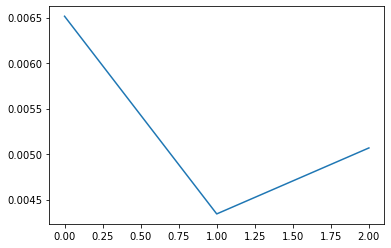

In [10]:
# Test with 1 sample
sample = np.genfromtxt(filenames_test[0], delimiter=',')
features = extract_features(sample, max_measurements, scale=raw_scale)
print(features.shape)
print(features)
plt.plot(features)

In [11]:
# Function: loop through filenames, creating feature sets
def create_feature_set(filenames):
    x_out = []
    for file in filenames:
        sample = np.genfromtxt(file, delimiter=',')
        features = extract_features(sample, max_measurements, raw_scale)
        x_out.append(features)
        
    return np.array(x_out)

In [12]:
# Create training, validation, and test sets
x_train = create_feature_set(filenames_train)
print('Extracted features from training set. Shape:', x_train.shape)
x_val = create_feature_set(filenames_val)
print('Extracted features from validation set. Shape:', x_val.shape)
x_test = create_feature_set(filenames_test)
print('Extracted features from test set. Shape:', x_test.shape)

Extracted features from training set. Shape: (181, 3)
Extracted features from validation set. Shape: (59, 3)
Extracted features from test set. Shape: (59, 3)


In [13]:
# Get input shape for 1 sample
sample_shape = x_train.shape[1:]
print(sample_shape)

(3,)


In [311]:
# Build model
# Based on: https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd
encoding_dim = 2       # Number of nodes in first layer
model = models.Sequential([
    layers.InputLayer(input_shape=sample_shape),
    layers.Dense(encoding_dim, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(*sample_shape, activation='relu')
])

# Display model
model.summary()

Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_216 (Dense)            (None, 2)                 8         
_________________________________________________________________
dropout_130 (Dropout)        (None, 2)                 0         
_________________________________________________________________
dense_217 (Dense)            (None, 3)                 9         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


In [312]:
# Add training parameters to model
model.compile(optimizer='adam',
             loss='mse')

In [313]:
# Train model (note Y labels are same as inputs, X)
history = model.fit(x_train,
                   x_train,
                   epochs=50,
                   batch_size=100,
                   validation_data=(x_val, x_val),
                   verbose=0)
print(history.history['val_loss'][-1])

1.388314922223799e-05


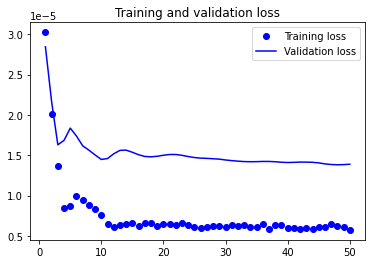

In [314]:
# Plot results
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Average MSE for normal validation set: 1.3883152315818027e-05
Standard deviation of MSE for normal validation set: 6.9041217649945e-05
Recommended threshold (3x std dev + avg): 0.00022100680526565303


(array([57.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([3.42165420e-08, 2.69051681e-05, 5.37761197e-05, 8.06470713e-05,
        1.07518023e-04, 1.34388975e-04, 1.61259926e-04, 1.88130878e-04,
        2.15001829e-04, 2.41872781e-04, 2.68743733e-04, 2.95614684e-04,
        3.22485636e-04, 3.49356587e-04, 3.76227539e-04, 4.03098490e-04,
        4.29969442e-04, 4.56840394e-04, 4.83711345e-04, 5.10582297e-04,
        5.37453248e-04]),
 <a list of 20 Patch objects>)

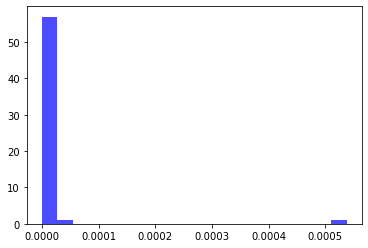

In [315]:
# Calculate MSE from validation set
predictions = model.predict(x_val)
normal_mse = np.mean(np.power(x_val - predictions, 2), axis=1)
print('Average MSE for normal validation set:', np.average(normal_mse))
print('Standard deviation of MSE for normal validation set:', np.std(normal_mse))
print('Recommended threshold (3x std dev + avg):', (3*np.std(normal_mse)) + np.average(normal_mse))
fig, ax = plt.subplots(1,1)
ax.hist(normal_mse, bins=20, label='normal', color='blue', alpha=0.7)

In [316]:
# Extract features from anomaly test set (truncate to length of X test set)
anomaly_ops_trunc = anomaly_op_filenames[0:len(normal_mse)]
anomaly_features = create_feature_set(anomaly_ops_trunc)
print('Extracted features from anomaly set. Shape:', anomaly_features.shape)

Extracted features from anomaly set. Shape: (59, 3)


In [317]:
# Calculate MSE from anomaly set
predictions = model.predict(anomaly_features)
anomaly_mse = np.mean(np.power(anomaly_features - predictions, 2), axis=1)
print('Average MSE for for anomaly test set:', np.average(anomaly_mse))

Average MSE for for anomaly test set: 0.0003165360143981702


(array([17., 13.,  7.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  2.,
         4.,  3.,  3.,  2.,  2.,  2.,  1.]),
 array([1.08091345e-06, 5.15882250e-05, 1.02095537e-04, 1.52602848e-04,
        2.03110160e-04, 2.53617471e-04, 3.04124783e-04, 3.54632095e-04,
        4.05139406e-04, 4.55646718e-04, 5.06154029e-04, 5.56661341e-04,
        6.07168652e-04, 6.57675964e-04, 7.08183276e-04, 7.58690587e-04,
        8.09197899e-04, 8.59705210e-04, 9.10212522e-04, 9.60719833e-04,
        1.01122715e-03]),
 <a list of 20 Patch objects>)

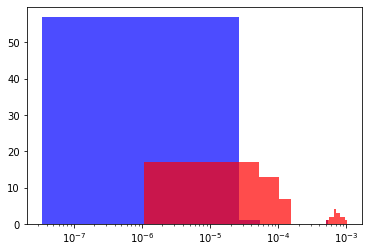

In [318]:
# Plot histograms of normal validation vs. anomaly sets (MSEs)
fig, ax = plt.subplots(1,1)
plt.xscale("log")
ax.hist(normal_mse, bins=20, label='normal', color='blue', alpha=0.7)
ax.hist(anomaly_mse, bins=20, label='anomaly', color='red', alpha=0.7)

In [319]:
# Look at separation using test set
predictions = model.predict(x_test)
normal_mse = np.mean(np.power(x_test - predictions, 2), axis=1)
print('Average MSE for normal test set:', np.average(normal_mse))

Average MSE for normal test set: 3.6699820572377385e-06


(array([17., 13.,  7.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  2.,
         4.,  3.,  3.,  2.,  2.,  2.,  1.]),
 array([1.08091345e-06, 5.15882250e-05, 1.02095537e-04, 1.52602848e-04,
        2.03110160e-04, 2.53617471e-04, 3.04124783e-04, 3.54632095e-04,
        4.05139406e-04, 4.55646718e-04, 5.06154029e-04, 5.56661341e-04,
        6.07168652e-04, 6.57675964e-04, 7.08183276e-04, 7.58690587e-04,
        8.09197899e-04, 8.59705210e-04, 9.10212522e-04, 9.60719833e-04,
        1.01122715e-03]),
 <a list of 20 Patch objects>)

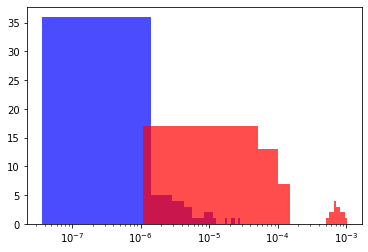

In [320]:
# Plot histograms of normal test vs. anomaly sets (MSEs)
fig, ax = plt.subplots(1,1)
plt.xscale("log")
ax.hist(normal_mse, bins=20, label='normal', color='blue', alpha=0.7)
ax.hist(anomaly_mse, bins=20, label='anomaly', color='red', alpha=0.7)

In [321]:
# If we're happy with the performance, save the model
model.save(keras_model_name + '.h5')

In [280]:
# Save a normal and anomaly sample for trying out on the MCU
normal_sample = np.genfromtxt(filenames_test[0], delimiter=',')
anomaly_sample = np.genfromtxt(anomaly_op_filenames[0], delimiter=',')
np.savez(sample_file_name + '.npz', normal_sample=normal_sample, anomaly_sample=anomaly_sample)

FileNotFoundError: [Errno 2] No such file or directory: 'test-samples\\normal_anomaly_samples.npz'

In [44]:
# Save the test dataset for use as a representative dataset
np.savez(rep_dataset_name + '.npz', x_test=x_test)

FileNotFoundError: [Errno 2] No such file or directory: 'test-samples\\normal_anomaly_test_set.npz'

In [322]:
# Create a classifier (0 = normal, 1 = anomaly)
def detect_anomaly(x, model, threshold=0):
    input_tensor = x_test[0].reshape(1, -1)
    pred = model.predict(input_tensor)
    mse = np.mean(np.power(x - pred, 2), axis=1)
    if mse > threshold:
        return 1
    else:
        return 0

In [323]:
# Choose a threshold
anomaly_threshold = 1e-05

In [324]:
# Perform classification on test set
pred_test = [detect_anomaly(x, model, anomaly_threshold) for x in x_test]
print(pred_test)

[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]


In [325]:
# Perform classification on anomaly set
pred_anomaly = [detect_anomaly(x, model, anomaly_threshold) for x in anomaly_features]
print(pred_anomaly)

[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]


In [326]:
# Combine predictions into one long list and create a label list
pred = np.array(pred_test + pred_anomaly)
labels = ([0] * len(pred_test)) + ([1] * len(pred_anomaly))

In [327]:
# Create confusion matrix
cm = confusion_matrix(labels, pred)
print(cm)

[[52  7]
 [ 8 51]]


Text(33.0, 0.5, 'Actual')

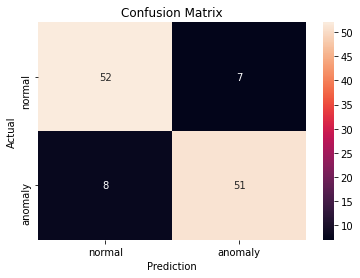

In [328]:
# Make confusion matrix pretty
df_cm = pd.DataFrame(cm, index=['normal', 'anomaly'], columns=['normal', 'anomaly'])
plt.figure()
sn.heatmap(df_cm, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual')